<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales</h1>
    <h3>Clase 4 - Modelo VAR</h3>
    <h3>Ejercicio 3</h3>
        <p>Docente: Rodrigo Del Rosso<p>
        <p>Asistente: Sebastián Calcagno y Braian Drago<p>
</div>

**Modelo VAR**  

Un modelo VAR es una generalización del modelo autorregresivo univariado para pronosticar un vector de series de tiempo. Comprende una ecuación por variable en el sistema. El lado derecho de cada ecuación incluye una constante y retrasos de todas las variables.

Si las series son estacionarias, se pronostican ajustando directamente un VAR a los datos (conocido como “VAR en niveles”). *Si las series no son estacionarias, tomamos las diferencias de los datos para hacerlas estacionarias y luego ajustamos un modelo VAR* (conocido como “VAR en diferencias”). En ambos casos, los modelos se estiman ecuación a ecuación utilizando el principio de mínimos cuadrados.

Los MODELOS VAR son útiles en varios contextos:

1. Pronosticar una colección de variables relacionadas donde no se requiere interpretación explícita;
2. Probar si una variable es útil para pronosticar otra (la base de las pruebas de causalidad de Granger);
3. Análisis de respuesta de impulso, donde se analiza la respuesta de una variable a un cambio repentino pero temporal en otra variable;

Se dice que dos o más series están cointegradas si las mismas se mueven conjuntamente a lo largo del tiempo y las diferencias entre ellas son estables (es decir estacionarias), aun cuando cada serie en particular contenga una tendencia estocástica y sea por lo tanto no estacionaria.

Entonces, la cointegración refleja la presencia de un equilibrio a largo plazo hacia el cual converge el sistema a lo largo del tiempo.

**Objetivo del Ejercicio**: Para el desarrollo del MODELO VAR, incorporamos la serie de precios del **Petróleo** junto con dos productos hidrocarburos más (todo expresado en USD/tn). A través del conocimiento del negocio, entendemos que ambos hidrocarburos (Benceno y Estireno) se producen como derivados del petróleo, entonces se analiza a continuación su relación y la respuestas a impulsos.

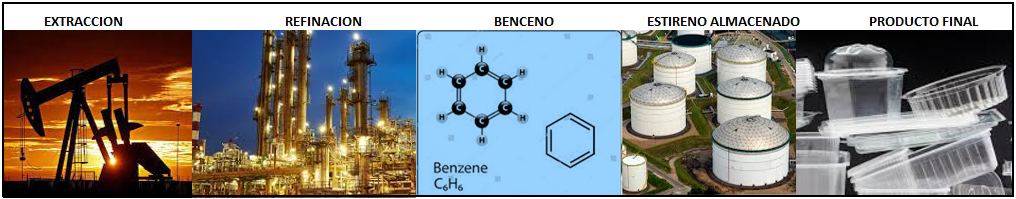

**Montaje de Drive personal para acceder a archivos/ datasets**

1.   Elemento de lista
2.   Elemento de lista



Carga de Librerías

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR  #
from statsmodels.tsa.statespace.varmax import VARMAX
from scipy.stats import pearsonr
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests, adfuller    #
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import jarque_bera, shapiro, boxcox, probplot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from sklearn.metrics import mean_squared_error
import math
from statistics import mean

Carga de datos

In [ ]:
url='https://raw.githubusercontent.com/sebcalcagno/AnalisisSeriesTemporales/main/Estireno_base.csv'
Estireno = pd.read_csv(url,  parse_dates=['FECHA'], index_col='FECHA')
Estireno.head()

,STYRENE FOB ARA US$-TON
FECHA,
2006-01-01,1143.41579
2006-02-01,1106.04782
2006-03-01,1015.87968
2006-04-01,1023.92647
2006-05-01,1127.32221


In [ ]:
url='https://raw.githubusercontent.com/sebcalcagno/AnalisisSeriesTemporales/main/Benceno_base.csv'
Benceno = pd.read_csv(url,  parse_dates=['FECHA'], index_col='FECHA')
Benceno.head()

,BENCENO SPOT USGC US$-TON
FECHA,
2006-01-01,818.03410
2006-02-01,841.84945
2006-03-01,807.74850
2006-04-01,865.11165
2006-05-01,928.05115


In [ ]:
url='https://raw.githubusercontent.com/braiandrago/AST/main/petroleo_wti.csv'
Petroleo = pd.read_csv(url,  parse_dates=['FECHA'], index_col='FECHA')
Petroleo.head()

<ipython-input-66-af70ac2a7329>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Petroleo = pd.read_csv(url,  parse_dates=['FECHA'], index_col='FECHA')


,CRUDE_OIL_WTI
FECHA,
2006-01-01,486.7393
2006-02-01,457.9109
2006-03-01,467.3470
2006-04-01,517.7967
2006-05-01,527.0842


In [ ]:
precios = Estireno.merge(Benceno,on='FECHA').merge(Petroleo,on='FECHA')
print(precios)

            STYRENE FOB ARA US$-TON  BENCENO SPOT USGC US$-TON  CRUDE_OIL_WTI
FECHA                                                                        
2006-01-01               1143.41579                  818.03410       486.7393
2006-02-01               1106.04782                  841.84945       457.9109
2006-03-01               1015.87968                  807.74850       467.3470
2006-04-01               1023.92647                  865.11165       517.7967
2006-05-01               1127.32221                  928.05115       527.0842
...                             ...                        ...            ...
2015-08-01               1087.74964                  684.71000       318.5241
2015-09-01                846.56640                  609.96000       337.9164
2015-10-01                846.34594                  635.64410       343.4146
2015-11-01                854.50296                  687.37110       315.3292
2015-12-01                845.02318                  642.70050  

In [ ]:
precios  = precios .asfreq(pd.infer_freq(precios .index))

In [ ]:
precios.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2006-01-01 to 2015-12-01
Freq: MS
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   STYRENE FOB ARA US$-TON    120 non-null    float64
 1   BENCENO SPOT USGC US$-TON  120 non-null    float64
 2   CRUDE_OIL_WTI              120 non-null    float64
dtypes: float64(3)
memory usage: 3.8 KB


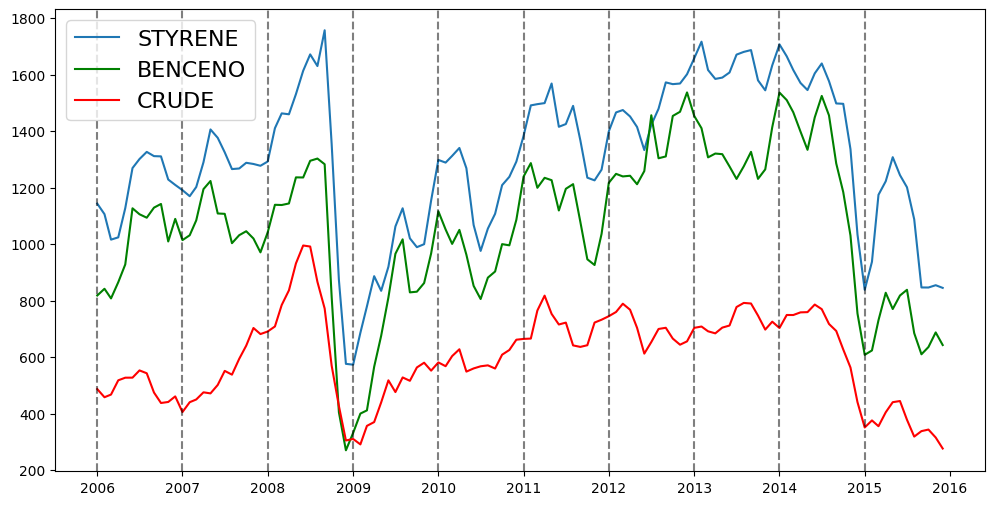

In [ ]:
plt.figure(figsize=(12,6))
STYRENE, = plt.plot(precios ['STYRENE FOB ARA US$-TON'])
BENCENO, = plt.plot(precios ['BENCENO SPOT USGC US$-TON'], color='green')
CRUDE, = plt.plot(precios ['CRUDE_OIL_WTI'], color='red')

for year in range(2006, 2016):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.legend(['STYRENE', 'BENCENO','CRUDE'], fontsize=16);

**Estacionariedad?**

Para una serie temporal estacionaria, el ACF caerá a cero con relativa rapidez, mientras que el ACF de datos no estacionarios disminuye lentamente. (https://otexts.com/fpp2/stationarity.html)

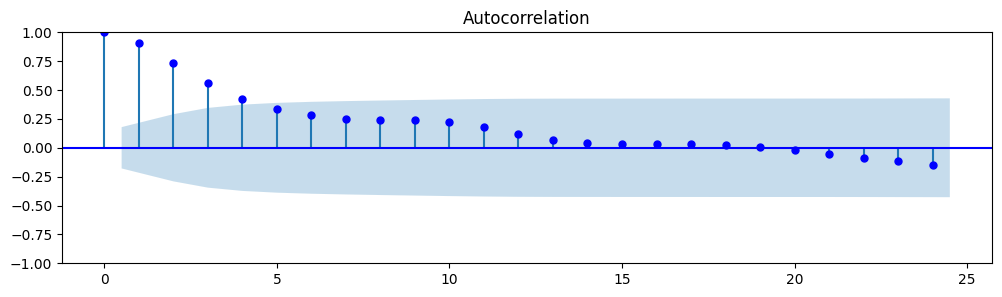

In [ ]:
acf_plot = plot_acf(precios ['STYRENE FOB ARA US$-TON'], lags=24,  color= 'blue')
acf_plot.set_size_inches(12,3)

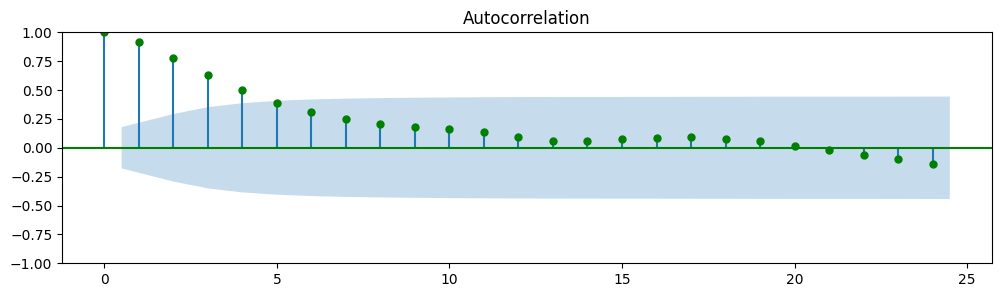

In [ ]:
acf_plot = plot_acf(precios ['BENCENO SPOT USGC US$-TON'], lags=24,  color= 'green')
acf_plot.set_size_inches(12,3)

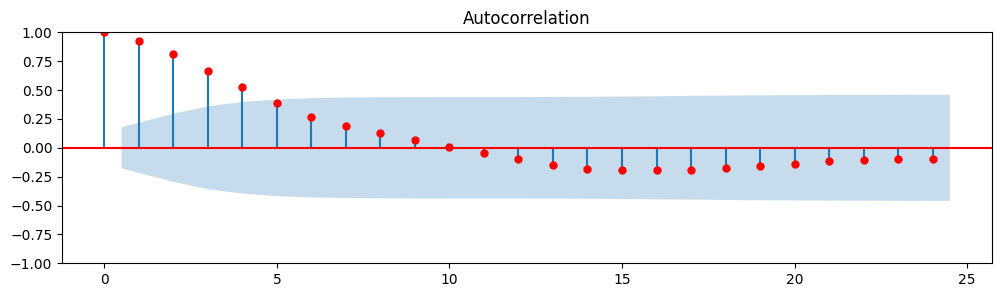

In [ ]:
acf_plot = plot_acf(precios ['CRUDE_OIL_WTI'], lags=24,  color= 'red')
acf_plot.set_size_inches(12,3)

In [ ]:
print(pm.arima.ndiffs(precios['STYRENE FOB ARA US$-TON']))

0


In [ ]:
print(pm.arima.ndiffs(precios['BENCENO SPOT USGC US$-TON']))

0


In [ ]:
print(pm.arima.ndiffs(precios['CRUDE_OIL_WTI']))

0


Ho es la hipotesis nula. La serie tiene una raiz unitaria, la serie NO es estacionaria.

In [ ]:
# Test de Dickey-Fuller
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(precios['STYRENE FOB ARA US$-TON'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.850392
p-value                          0.051428
#Lags Used                       2.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64


In [ ]:
test_stationarity(precios['BENCENO SPOT USGC US$-TON'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.686257
p-value                          0.076447
#Lags Used                       2.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64


In [ ]:
test_stationarity(precios['CRUDE_OIL_WTI'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.988323
p-value                          0.035999
#Lags Used                       2.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64


**Cointegración?**

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.coint.html

In [ ]:
from statsmodels.tsa.stattools import coint


La hipótesis nula es NO HAY COINTEGRACION. Si p-value > 0.05, NO rechazamos H0.

In [ ]:
coint(precios['BENCENO SPOT USGC US$-TON'],precios ['CRUDE_OIL_WTI'])

(-2.6367300311097583,
 0.22315428572217233,
 array([-3.99084033, -3.38795719, -3.08028241]))

p-value of 0.2231 -> NO rechazamos la hipótesis nula.

Decimos que: No hay evidencia de cointegración entre Benceno y Crudo.

In [ ]:
coint(precios['BENCENO SPOT USGC US$-TON'],precios ['STYRENE FOB ARA US$-TON'])

(-4.936871716835145,
 0.0002147216727379106,
 array([-3.99084033, -3.38795719, -3.08028241]))

In [ ]:
coint(precios['STYRENE FOB ARA US$-TON'],precios ['CRUDE_OIL_WTI'])

(-3.319498422571883,
 0.0521115292920656,
 array([-3.99084033, -3.38795719, -3.08028241]))

**Causalidad de Granger**

El Test de Granger permite entender y analizar si los valores pasados de una variable *x* podrían ayudar a la predicción de los valores futuros de una variable *y*.  

H0:"Serie x" NO CAUSA en el sentido de Granger a "serie y" (p-value > 0.05 No Rechazo H0)  
H1:"Serie x" CAUSA en el sentido de Granger a "serie y"

A continuación, se analiza las relaciones de los precios de los hidrocarburos.


In [ ]:
print('Petroleo causes Estireno?\n')
print('------------------')
granger_1 = grangercausalitytests(precios[['STYRENE FOB ARA US$-TON', 'CRUDE_OIL_WTI']], 3)

print('------------------')
print('------------------')

print('\Estireno causes Petroleo?\n')
print('------------------')
granger_2 = grangercausalitytests(precios[['CRUDE_OIL_WTI', 'STYRENE FOB ARA US$-TON']], 3)

Petroleo causes Estireno?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.8963 , p=0.0013  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=11.1781 , p=0.0008  , df=1
likelihood ratio test: chi2=10.6838 , p=0.0011  , df=1
parameter F test:         F=10.8963 , p=0.0013  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=14.0715 , p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=29.3883 , p=0.0000  , df=2
likelihood ratio test: chi2=26.2416 , p=0.0000  , df=2
parameter F test:         F=14.0715 , p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=10.0132 , p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=31.9511 , p=0.0000  , df=3
likelihood ratio test: chi2=28.2490 , p=0.0000  , df=3
parameter F test:         F=10.0132 , p=0.0000  , df_denom=110, df_num=3
------------------
------------------
\Estireno 

En base al estadístico, podría decirse que valores pasados de *Petroleo* podrían ayudar a predecir los valores futuros de *Estireno*. El p-value arrojado es de 0.0000 ** por lo que se rechaza la no causalidad, afirmando que existe causalidad.

In [ ]:
print('Benceno causes Estireno?\n')
print('------------------')
granger_1 = grangercausalitytests(precios[['STYRENE FOB ARA US$-TON', 'BENCENO SPOT USGC US$-TON']], 3)

print('\Estireno causes Benceno?\n')
print('------------------')
granger_2 = grangercausalitytests(precios[['BENCENO SPOT USGC US$-TON', 'STYRENE FOB ARA US$-TON']], 3)

Benceno causes Estireno?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=25.9829 , p=0.0000  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=26.6548 , p=0.0000  , df=1
likelihood ratio test: chi2=24.0518 , p=0.0000  , df=1
parameter F test:         F=25.9829 , p=0.0000  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.1633 , p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=23.3146 , p=0.0000  , df=2
likelihood ratio test: chi2=21.2759 , p=0.0000  , df=2
parameter F test:         F=11.1633 , p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.9219  , p=0.0003  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=22.0872 , p=0.0001  , df=3
likelihood ratio test: chi2=20.2325 , p=0.0002  , df=3
parameter F test:         F=6.9219  , p=0.0003  , df_denom=110, df_num=3
\Estireno causes Benceno?

------------------

Gr

En base al estadístico, podría decirse que valores pasados de Benceno podrían ayudar a predecir los valores futuros de Estireno. El p-value arrojado es de 0.0000 ** por lo que se rechaza la no causalidad, afirmando que existe causalidad.

**Modelo VAR**

In [ ]:
train_df=precios[:-12]
test_df=precios[-12:]

In [ ]:
model = VAR(train_df.diff()[1:])

In [ ]:
sorted_order=model.select_order(maxlags=25)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        26.39       26.48   2.900e+11       26.43
1        26.18       26.54   2.348e+11       26.32
2        25.82       26.44   1.642e+11       26.07
3        25.81       26.70   1.622e+11       26.16
4        25.43       26.59   1.120e+11       25.90
5        25.41       26.83   1.105e+11       25.98
6        25.49       27.17   1.203e+11       26.16
7        25.60       27.55   1.361e+11       26.38
8        25.62       27.83   1.421e+11       26.51
9        25.67       28.15   1.534e+11       26.66
10       25.47       28.22   1.305e+11       26.57
11       25.48       28.50   1.380e+11       26.69
12       25.40       28.68   1.340e+11       26.72
13       25.34       28.89   1.343e+11       26.76
14       25.31       29.13   1.414e+11       26.84
15       25.28       29.36   1.506e+11       26.92
16       25.14       29.49   1.

In [ ]:
sorted_order=model.select_order(maxlags=12)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        26.19       26.27   2.355e+11       26.22
1        25.91       26.23   1.783e+11       26.04
2        25.58      26.15*   1.286e+11       25.81
3        25.52       26.33   1.213e+11       25.85
4        25.30       26.36   9.803e+10      25.73*
5        25.24       26.54  9.283e+10*       25.77
6        25.28       26.82   9.674e+10       25.90
7        25.37       27.15   1.068e+11       26.09
8        25.35       27.38   1.063e+11       26.17
9        25.37       27.64   1.105e+11       26.29
10       25.22       27.74   9.716e+10       26.24
11       25.22       27.98   9.983e+10       26.34
12      25.17*       28.17   9.760e+10       26.38
--------------------------------------------------


In [ ]:
results = model.fit(maxlags=2,
                    ic='aic',
                    verbose=1
                   )

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 2, BIC -> 1, FPE -> 2, HQIC ->  2>
Using 2 based on aic criterion


In [ ]:
print(results.summary()._resid_info())

Correlation matrix of residuals
                             STYRENE FOB ARA US$-TON  BENCENO SPOT USGC US$-TON  CRUDE_OIL_WTI
STYRENE FOB ARA US$-TON                     1.000000                   0.769252       0.367140
BENCENO SPOT USGC US$-TON                   0.769252                   1.000000       0.351804
CRUDE_OIL_WTI                               0.367140                   0.351804       1.000000




Errores correlacionados. En este caso, parece haber correlaciones positivas significativas entre los residuos de las tres variables, lo que sugiere que podría haber relaciones de corto plazo entre estas variables en el modelo VAR.

In [ ]:
normality = results.test_normality()
print(normality.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         12.29          12.59   0.056  6
----------------------------------------


No podemos rechazar normalidad en los residuos

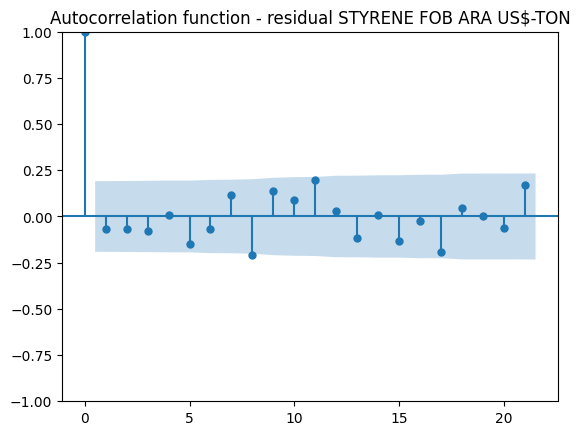

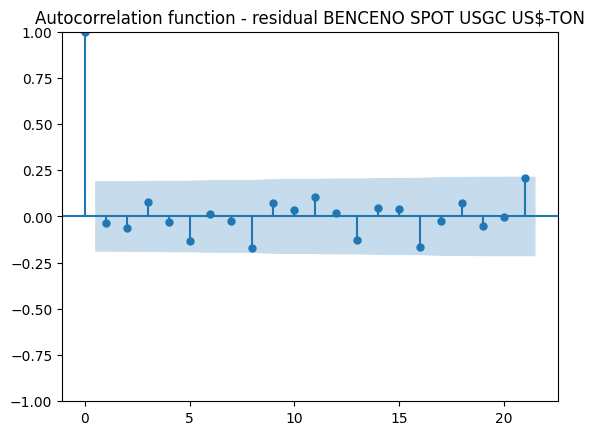

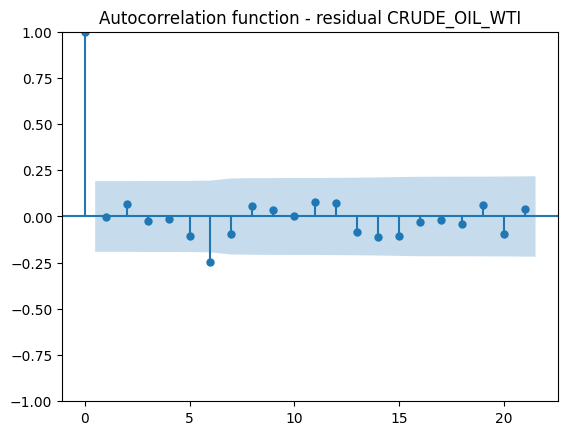

In [ ]:
for quant in precios.columns:
    plot_acf(results.resid[quant],title='Autocorrelation function - residual {}'.format(quant))

Los gráficos de los residuos muestran que no hay autocorrelaciones en cada residuo, como sería de esperar si el modelo utilizado se ajustara bien a los datos.

**Impuso Respuesta**  

Para comprender mejor cómo el cambio de una cantidad en el pasado influye en otra cantidad en el presente, podemos utilizar la respuesta impulsiva. La idea es que comencemos con un cambio de unidad para una sola cantidad en n
  rezagos y estudiar cómo se propaga este shock en otra variable.

Consideraremos la función impulso-respuesta para aquellas variables que están relacionadas causalmente con Granger.

A través de la relación impulso - respuesta, calculando el efecto sobre Estireno a partir de un impulso unitario en Petroleo, se observa:

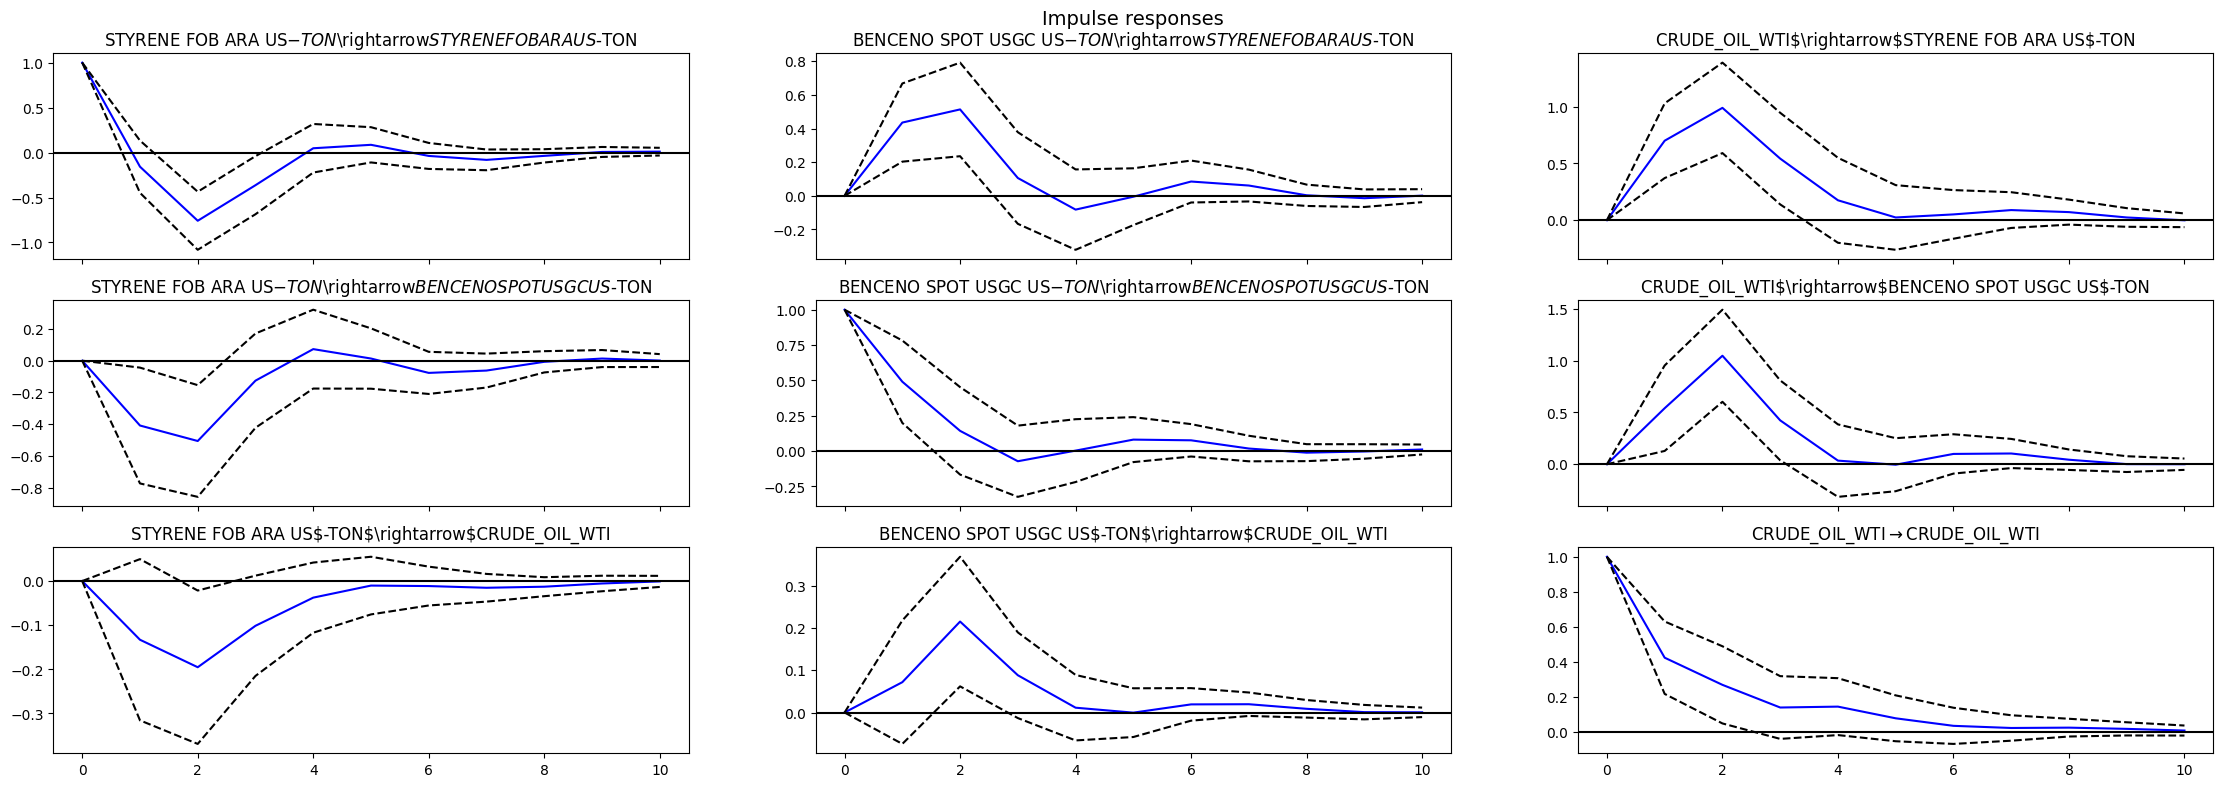

In [ ]:
# Impulse response function for the model we trained
irf = results.irf(periods=10)
irf.plot(figsize=(24,8)) #Impulse response function plot
plt.show()

In [ ]:
fevd = results.fevd(10)

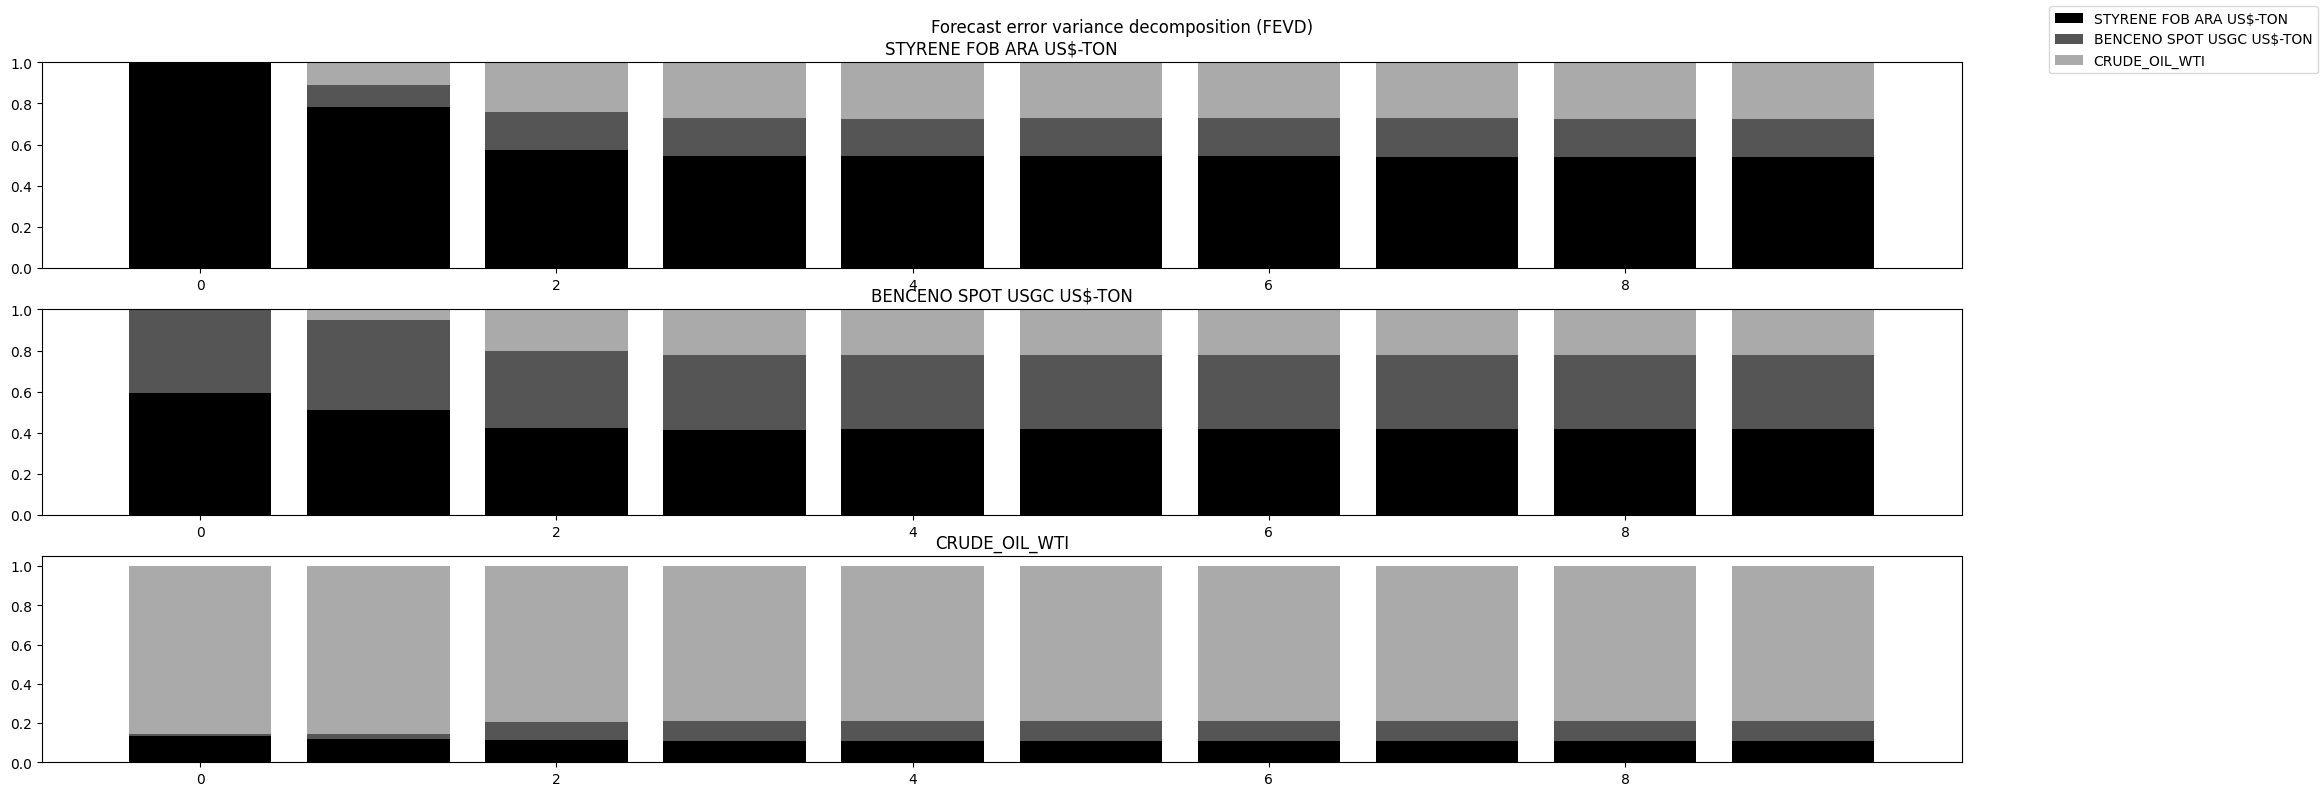

In [ ]:
fevd.plot(figsize=(24,8)) #Impulse response function plot
plt.show()

In [ ]:
fevd.summary()

FEVD for STYRENE FOB ARA US$-TON
     STYRENE FOB ARA US$-TON  BENCENO SPOT USGC US$-TON  CRUDE_OIL_WTI
0                   1.000000                   0.000000       0.000000
1                   0.785158                   0.104809       0.110033
2                   0.572275                   0.187599       0.240125
3                   0.546112                   0.183043       0.270844
4                   0.542849                   0.183247       0.273904
5                   0.544345                   0.182614       0.273041
6                   0.543524                   0.184163       0.272313
7                   0.542133                   0.185050       0.272816
8                   0.541767                   0.184904       0.273330
9                   0.541697                   0.184922       0.273381

FEVD for BENCENO SPOT USGC US$-TON
     STYRENE FOB ARA US$-TON  BENCENO SPOT USGC US$-TON  CRUDE_OIL_WTI
0                   0.591749                   0.408251       0.000000
1       

Interpretacion: Observando por ejemplo el período 5, Dado un impulso en la variable Estireno, el 54% esta explicado por ella misma,  el 18% Por el Benceno y un 27% Por el petróleo.

**Forecast**

In [ ]:
# Get the lag order
lag_order = results.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = train_df.values[-lag_order:]
forecast_input

2


array([[1336.20806, 1030.3839 ,  563.1197 ],
       [1034.39832,  754.4667 ,  440.5247 ]])

In [ ]:
# Forecast
n_forecast = 12
fc = results.forecast(y=forecast_input, steps=n_forecast)
df_forecast = pd.DataFrame(fc, index=precios.index[-n_forecast:], columns=precios.columns + '_1d')
df_forecast

,STYRENE FOB ARA US$-TON_1d,BENCENO SPOT USGC US$-TON_1d,CRUDE_OIL_WTI_1d
FECHA,,,
2015-01-01,436.786590,302.057728,222.138237
2015-02-01,177.830453,181.619327,141.291800
2015-03-01,147.543685,160.514918,85.693717
2015-04-01,152.569548,136.702524,61.902019
2015-05-01,101.982741,71.558707,41.060361
2015-06-01,43.303329,26.540001,25.283601
2015-07-01,15.208288,14.772900,13.275692
2015-08-01,12.854929,16.348997,7.141590
2015-09-01,13.442330,12.560071,4.476374


Invertimos las transformaciones: queremos revertir las transformaciones que se han aplicado previamente a un conjunto de datos con el fin de obtener pronósticos

In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = train_df.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (train_df[col].iloc[-1]-train_df[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = train_df[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [ ]:
df_results = invert_transformation(train_df, df_forecast, second_diff=False)
df_results.loc[:, ['STYRENE FOB ARA US$-TON_forecast', 'BENCENO SPOT USGC US$-TON_forecast', 'CRUDE_OIL_WTI_forecast']]

,STYRENE FOB ARA US$-TON_forecast,BENCENO SPOT USGC US$-TON_forecast,CRUDE_OIL_WTI_forecast
FECHA,,,
2015-01-01,1471.184910,1056.524428,662.662937
2015-02-01,1649.015363,1238.143755,803.954738
2015-03-01,1796.559048,1398.658673,889.648454
2015-04-01,1949.128596,1535.361197,951.550473
2015-05-01,2051.111337,1606.919904,992.610834
2015-06-01,2094.414665,1633.459905,1017.894435
2015-07-01,2109.622954,1648.232805,1031.170128
2015-08-01,2122.477883,1664.581802,1038.311718
2015-09-01,2135.920213,1677.141873,1042.788092


Las previsiones vuelven a la escala original. Trazamos los pronósticos con los datos reales de los datos de prueba.

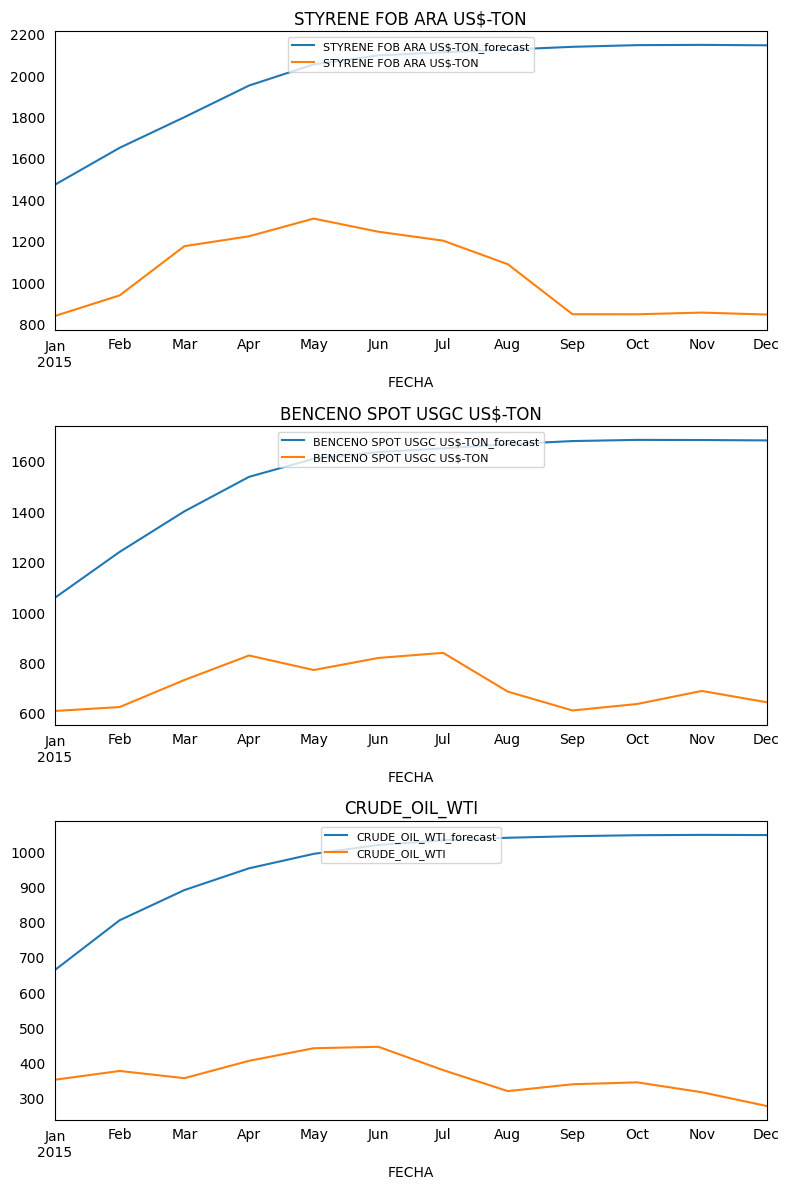

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=100, figsize=(8, 12))

for i, (col,ax) in enumerate(zip(precios.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test_df[col][-n_forecast:].plot(legend=True, ax=ax);
    ax.set_title(col)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    #ax.tick_params(labelsize=6, direction= 'out')
    ax.legend(fontsize="8",loc='upper center')

plt.tight_layout()
plt.show();

**Evaluate the Forecasts**

In [ ]:
rmse_estireno=math.sqrt(mean_squared_error(df_results['STYRENE FOB ARA US$-TON_forecast'],test_df['STYRENE FOB ARA US$-TON']))
print('Mean value of Estireno is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['STYRENE FOB ARA US$-TON']),rmse_estireno))

rmse_benceno=math.sqrt(mean_squared_error(df_results['BENCENO SPOT USGC US$-TON_forecast'],test_df['BENCENO SPOT USGC US$-TON']))
print('Mean value of Benceno is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['BENCENO SPOT USGC US$-TON']),rmse_benceno))

rmse_petroleo=math.sqrt(mean_squared_error(df_results['CRUDE_OIL_WTI_forecast'],test_df['CRUDE_OIL_WTI']))
print('Mean value of Petroleo is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['CRUDE_OIL_WTI']),rmse_petroleo))

Mean value of Estireno is : 1033.84717. Root Mean Squared Error is :987.0204615638307
Mean value of Benceno is : 706.4074333333333. Root Mean Squared Error is :856.5176028915965
Mean value of Petroleo is : 361.7543166666667. Root Mean Squared Error is :616.4600295462549
